# Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns


# Read images

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_images(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_images('dataset/chest_xray/train')
test  = get_images('dataset/chest_xray/test')
val   = get_images('dataset/chest_xray/val')

C:\Users\FELIPE~1\AppData\Local\Temp/ipykernel_10540/3700222522.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


C:\Users\felipeymn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

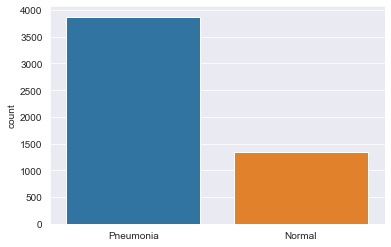

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

In [5]:
def split(data):
    x, y = map(lambda output: np.array(output), zip(*data))
    return x, y

x_train, y_train = split(train)
x_test, y_test = split(test)
x_val, y_val = split(val)

In [7]:
num_classes = 2

model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size, img_size, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [10]:
epochs = 5
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=epochs
)


Epoch 1/5
163/163 [==============================] - 24s 144ms/step - loss: 7.6035 - accuracy: 0.7393 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 24s 145ms/step - loss: 7.6472 - accuracy: 0.7429 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 24s 147ms/step - loss: 7.6472 - accuracy: 0.7429 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 4/5
163/163 [==============================] - 23s 143ms/step - loss: 7.6472 - accuracy: 0.7429 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 5/5
163/163 [==============================] - 23s 141ms/step - loss: 7.6472 - accuracy: 0.7429 - val_loss: 7.6685 - val_accuracy: 0.5000


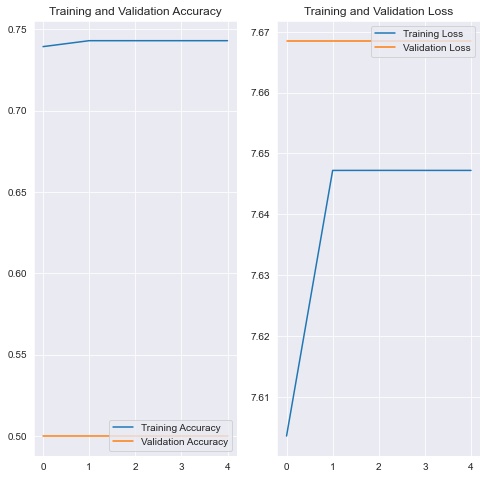

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
evaluate = model.evaluate(np.array(x_test), np.array(y_test))

print("Loss of the model is - ", evaluate[0])
print("Accuracy of the model is - ", evaluate[1]*100, "%")


20/20 [==============================] - 1s 32ms/step - loss: 7.6576 - accuracy: 0.6250
Loss of the model is -  7.657564640045166
Accuracy of the model is -  62.5 %


In [20]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)


In [21]:
confusion = tf.math.confusion_matrix(labels=y_test, predictions=predictions, num_classes=num_classes)
print(confusion)

tf.Tensor(
[[390   0]
 [234   0]], shape=(2, 2), dtype=int32)


<AxesSubplot:>

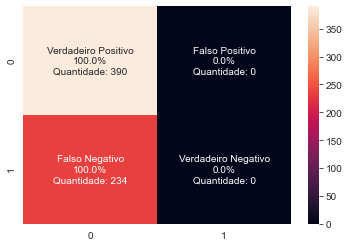

In [19]:
group_counts = [value for value in np.array(confusion).flatten()]
group_names = ['Verdadeiro Positivo', 'Falso Positivo', 'Falso Negativo', 'Verdadeiro Negativo']
group_percentages = []
for index, line in enumerate(confusion):
  for item in line:
    group_percentages.append(item.numpy()/np.sum(line))

annotations = [f'{name}\n{round(percentage, 2)*100}%\nQuantidade: {count}' for name, count,
               percentage in zip(group_names ,group_counts, group_percentages)]

annotations = np.asarray(annotations).reshape(2, 2)

sns.heatmap(confusion,  annot=annotations, fmt='')


In [6]:
# undersample = RandomUnderSampler(sampling_strategy='majority')
# oversample = RandomOverSampler(sampling_strategy='minority')

# x_train_flat = []
# for image in x_train:
#   x_train_flat.append(image.flatten())

# x_over, y_over = undersample.fit_resample(x_train_flat, y_train)

# x_train = []
# for image in x_over:
#   x_train.append(np.array(image).reshape(150, 150))

